In [1]:
import sys
import os
# Get current directory
current_dir = os.getcwd()
# Get parent directory
parent_dir = os.path.join(current_dir, '..')
# Append parent directory to sys.path
sys.path.append(parent_dir)



In [2]:
from wordcloud import WordCloud
import pandas as pd
import os
import pathlib
import gensim
import pyLDAvis
import numpy as np
import pyLDAvis.gensim
from gensim import models,corpora
from gensim.models.ldamodel import LdaModel
import matplotlib.pyplot as plt
from src.aspect_classification.data.data_cleaning import gensim_processing
from scipy.sparse import csr_matrix
from dotenv import load_dotenv
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [3]:
homepath = os.getenv('LOCAL_ENV')
# /Users/mylene/BachelorsProject/Venue-Accessibility-Google-Reviews/data/processed/aspect_classification_data/euans_reviews.csv
euans_path = homepath + 'data/processed/aspect_classification_data/processed_euans_reviews.csv'
google_path = homepath + 'data/processed/aspect_classification_data/processed_google_reviews.csv'
euans_data = pd.read_csv(euans_path)
google_data = pd.read_csv(google_path)

# Exploratory Data Analysis

### Firstly, I have created some visualisations linked to the Euans Guide data that will be used for training to understand the propotions of the features that we will be focusing on in the pipeline.


In [4]:
wordcloud = WordCloud(background_color='white', max_words=1000, contour_width=3, contour_color='steeleblue')
clustered_reviews_train = ','.join(list(euans_data['Text'].values))
train_wc = wordcloud.generate(clustered_reviews_train)
train_wc.to_file(homepath + "reports/figures/euans_word_cloud.png")

/Users/mylene/opt/anaconda3/envs/BachelorsProject/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/mylene/opt/anaconda3/envs/BachelorsProject/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/mylene/opt/anaconda3/envs/BachelorsProject/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/mylene/opt/anaconda3/envs/BachelorsProject/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize 

In [5]:
amount_per_aspect = euans_data.groupby(['Aspect']).count()
amount_per_aspect = amount_per_aspect['Text']

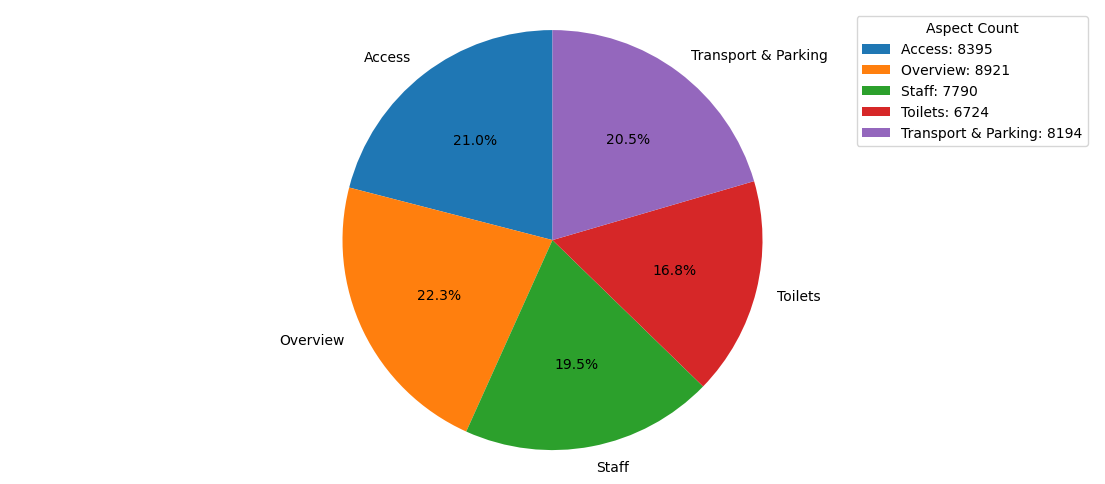

In [6]:
# Create a pie chart of the aspect counts
fig, ax = plt.subplots(figsize=(14, 6))
labels = amount_per_aspect.index
sizes = amount_per_aspect.values
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')

# Add a legend with the aspect counts
legend_labels = [f"{label}: {size}" for label, size in zip(labels, sizes)]
ax.legend(legend_labels, title="Aspect Count", loc="best")

# Set the file path to save the plot to
aspects_file_path = homepath + "reports/figures/euans_aspects_amounts_piechart_with_stats.png"

# Save the plot to the file path
plt.savefig(aspects_file_path, bbox_inches='tight')

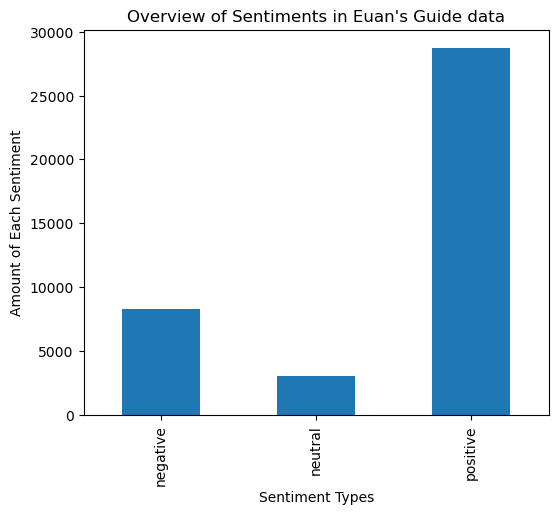

In [7]:
amount_per_sentiment = euans_data.groupby(['Sentiment']).count()
amount_per_sentiment = amount_per_sentiment['Text']
plot = amount_per_sentiment.plot(kind='bar', title="Overview of Sentiments in Euan's Guide data", ylabel='Amount of Each Sentiment', xlabel='Sentiment Types', figsize=(6,5))

# Set the file path to save the plot to
sentiment_file_path = homepath +"reports/figures/euans_sentiment_count.png"

# Save the plot to the file path
plot.get_figure().savefig(sentiment_file_path)


#### Next, I will do some topic modelling with the Google Reviews data, because this data is not labelled in respect to the matching aspects in Euans Guide. 

#### This will help us investigate what common topics exist in this data so that when I perform my labelling experiment. I know what categories are over-represented and under-represented in my sample.

In [8]:
tokenised_google_reviews = google_data['Text'].apply(gensim_processing)

dictionary = gensim.corpora.Dictionary(tokenised_google_reviews)

In [9]:
# Filter the dictionary to remove rare and common tokens
dictionary.filter_extremes(no_below=5, no_above=0.5)

In [10]:
google_corpus = [dictionary.doc2bow(review) for review in tokenised_google_reviews]
# Load environment variables from .env file
load_dotenv()


True

In [11]:
print(google_corpus[:2])

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1)], [(0, 2), (5, 1), (10, 1), (13, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1)]]


In [12]:
tfidf_model_path = homepath + 'models/aspect_classification/eda/lda_tfidf.lda'
print(tfidf_model_path)
loaded_model = LdaModel.load(tfidf_model_path)

/Users/mylene/BachelorsProject/Venue-Accessibility-Google-Reviews/models/aspect_classification/eda/lda_tfidf.lda


In [13]:
# create a bag-of-words representation of the new documents
new_corpus = [loaded_model.id2word.doc2bow(doc) for doc in tokenised_google_reviews]

# get the topic distribution for each new document
new_doc_topics = [loaded_model.get_document_topics(doc) for doc in new_corpus]

In [14]:
len(new_doc_topics)

399723

In [15]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from scipy.sparse import csr_matrix
import pandas as pd

# Create a matrix of the topic distributions
doc_topic_matrix = csr_matrix((len(new_doc_topics), loaded_model.num_topics))
doc_topic_matrix_dense = doc_topic_matrix.toarray()
for i, doc_topics in enumerate(new_doc_topics):
    for topic, prob in doc_topics:
        doc_topic_matrix_dense[i, topic] = prob

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
doc_topic_matrix_reduced = tsne.fit_transform(doc_topic_matrix_dense)

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(doc_topic_matrix_reduced)

# Calculate cluster sizes
cluster_sizes = pd.Series(dbscan_clusters).value_counts()

print(cluster_sizes)


 126     5701
-1       3838
 1       3501
 317     2978
 15      2750
         ... 
 4509       4
 4717       4
 4769       4
 4749       4
 3134       4
Length: 4774, dtype: int64


In [16]:
sorted_cluster_sizes = cluster_sizes.sort_values()

In [ ]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert the tokenized text data to strings
text_strings = [' '.join(tokens) for tokens in tokenised_google_reviews]

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Apply TF-IDF transformation to your text data
X = vectorizer.fit_transform(text_strings)

# Define the number of desired clusters
n_clusters = 4774

# Apply NMF to extract topics/clusters
nmf = NMF(n_components=n_clusters, random_state=42)
nmf.fit(X)

# Define the relevant keywords related to disability
relevant_keywords = ['disability', 'accessibility', 'wheelchair', 'entrance', 'noise']

# Set batch size for processing
batch_size = 682

# Initialize the relevant topics dictionary
relevant_topics = {}

# Iterate through clusters in batches
for batch_start in range(0, n_clusters, batch_size):
    batch_end = min(batch_start + batch_size, n_clusters)

    # Process the current batch of clusters
    for topic_idx in range(batch_start, batch_end):
        topic = nmf.components_[topic_idx]
        top_words = [vectorizer.get_feature_names()[i] for i in topic.argsort()[:-10 - 1:-1]]

        # Check if any of the relevant keywords are present in the top words
        for keyword in relevant_keywords:
            if keyword in top_words:
                print(f"Found relevant topic in cluster {topic_idx} for keyword: {keyword}.")
                # Check if the keyword is already present in the dictionary
                if keyword in relevant_topics:
                    # Append the topic index to the existing list
                    relevant_topics[keyword].append(topic_idx)
                else:
                    # Create a new list with the topic index
                    relevant_topics[keyword] = [topic_idx]



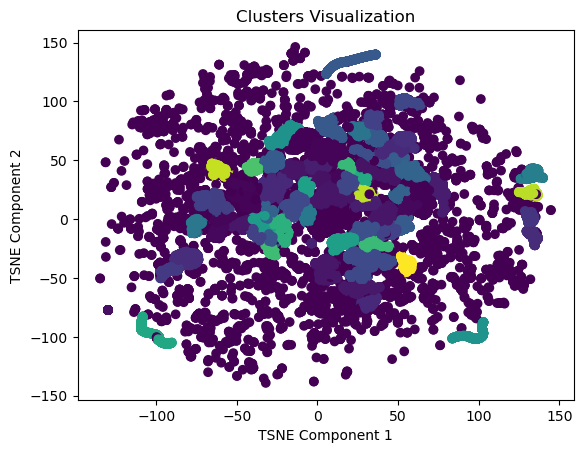

In [26]:
import numpy as np
# Define the number of clusters to visualize
n_clusters = 75  # Specify the desired number of clusters to plot

# Get the cluster labels and sizes
cluster_labels = np.unique(dbscan_clusters)
cluster_sizes = pd.Series(dbscan_clusters).value_counts()

# Select clusters based on criteria (e.g., top N clusters)
selected_clusters = cluster_sizes.nlargest(n_clusters).index

# Filter the data points belonging to the selected clusters
selected_data = doc_topic_matrix_reduced[np.isin(dbscan_clusters, selected_clusters)]

# Generate scatter plot
plt.scatter(selected_data[:, 0], selected_data[:, 1], c=dbscan_clusters[np.isin(dbscan_clusters, selected_clusters)])
plt.title('Clusters Visualization')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.show()

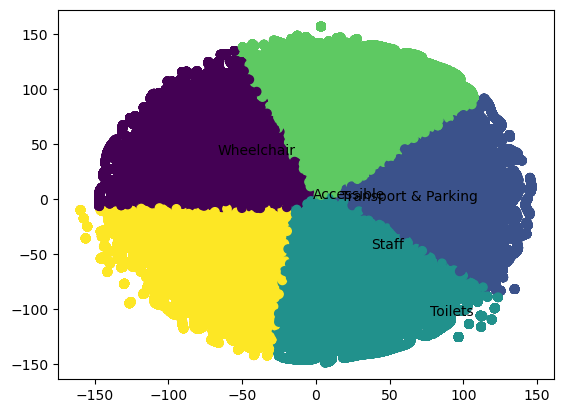

In [ ]:
# Choose a different plot and check pre-processing with gensim
# topic_labels = ['Toilets', 'Transport & Parking', 'Staff', 'Accessible', 'Wheelchair']
# plt.scatter(doc_topic_matrix_reduced[:, 0], doc_topic_matrix_reduced[:, 1], c=doc_clusters)
# for i, txt in enumerate(topic_labels):
#     plt.annotate(txt, (doc_topic_matrix_reduced[i, 0], doc_topic_matrix_reduced[i, 1]))
# plt.show()

In [ ]:
import top2vec

/Users/mylene/opt/anaconda3/envs/BachelorsProject/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-09 14:21:20.083016: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


do the cohens kappa thing